# Sentiment Analysis

---

In this notebook I have built an end-to-end sentiment classification system from scratch. The system accepts a movie review as input and classifies it as either positive or negative. There are three main steps:

* **Preprocess** - Split the data into train and test sets, tokenize, stem words, create bag-of-words features, etc.
* **Models** - Create and experiment with different models: GaussianNB, Gradient-Boosted Decision Tree classifier and Recurrent Neural Network.
* **Evaluation** - Compare the performances of the models and summarize steps to make the chosen model do better.

## Table of Contents

[Step 1: Explore the data](#step1)

[Step 2: Preprocess the data](#step2)

[Step 3: Extract Bag-of-words features](#step3)

[Step 4: Classification using BoW features](#step4)

[Step 5: Switching gears - RNNs](#step5)

[Step 6: Evaluation](#step6)

---

## Step 1: Exploring the data <a class="anchor" id="step1"></a>

The [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

### Load the dataset

In [1]:
import os
import glob
import pickle

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels

# Read imdb data and write them into pickle files
if not (os.path.isfile('data.pickle') and os.path.isfile('labels.pickle')):
    data, labels = read_imdb_data()
    with open("data.pickle", "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open("labels.pickle", "wb") as handle:
        pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

        
# Open the pickle files
if os.path.getsize("data.pickle") > 0:
    with open("data.pickle", "rb") as handle:
        data = pickle.load(handle)
else:
    print ("You're trying to load an empty file")

if os.path.getsize("data.pickle") > 0:
    with open("labels.pickle", "rb") as handle:
        labels = pickle.load(handle)
else:
    print ("You're trying to load an empty file"        )

print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][2])

Hood of the Living Dead had a lot to live up to even before the opening credits began. First, any play on "...of the living dead" invokes His Holiness Mr. Romero and instantly sets up a high standard to which many movies cannot afford to aspire. And second, my movie-watching companion professed doubt that any urban horror film would surpass the seminal Leprechaun In the Hood. Skeptical, we settled in to watch. <br /><br />We were rewarded with a surprisingly sincere and good-hearted zombie film. Oh, certainly the budget is low, and of course the directors' amateurs friends populate the cast, but Hood of the Living Dead loves zombie cinema. Cheap? Yeah. But when it's this cheap, you can clearly see where LOVE holds it together. <br /><br />Ricky works in a lab during the day and as a surrogate parent to his younger brother at night. He dreams of moving out of Oakland. Before this planned escape, however, his brother is shot to death in a drive-by. Ricky's keen scientific mind presents a

And one with a negative sentiment:

In [3]:
print(data['train']['neg'][2])

There was nothing about this movie that I liked. It was so obviously low-budget with bad lighting and camera work (almost like Blair Witch Project, only it wasn't supposed to be that way). There wasn't really much to the plot, and the movie just drug on and on. I actually fast-forwarded through the last 1/3 of the movies, but that did not help matters much. It looked like it might be good from the box, but I must say again: nothing about this movie even resembled good. No good actors, the special effects were so fake, the camera work was horrible, and the dialogue was painfully terrible. On my own personal scale, I give this movie a 0 of 10. Yikes!


### Make a wordcloud visualization of the reviews

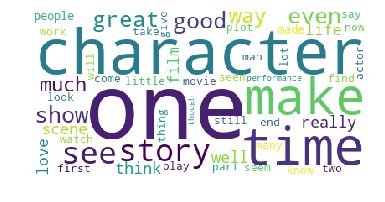

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

def wordcloud_by_sentiment(sentiment):
    """Create a wordcloud by sentiment.
    
    Parameters:
    sentiment: "pos"/"neg" string
    
    Returns: 
    A wordcloud of the reviews that have the given sentiment    
    """    
    # Combine all reviews for the desired sentiment
    combined_text = " ".join([review for review in data['train'][sentiment]])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50,
            # update stopwords to include common words like film and movie
            stopwords = STOPWORDS.update(['br','film','movie']))

    # Generate and plot wordcloud
    plt.imshow(wc.generate(combined_text))
    plt.axis('off')
    plt.show()

# Create a wordcloud from positive reviews    
wordcloud_by_sentiment('pos')

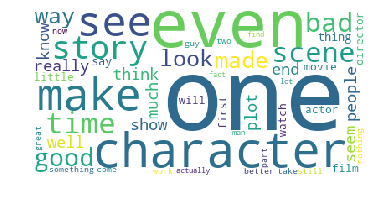

In [5]:
# Create a wordcloud from negative reviews
wordcloud_by_sentiment('neg')

### Form training and test sets

Combine the positive and negative documents to get one unified training set and one unified test set.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # Combine positive and negative reviews and labels
    data_train = data["train"]["pos"] + data["train"]["neg"]
    data_test = data["test"]["pos"] + data["test"]["neg"]
    labels_train = ["pos"] * len(data["train"]["pos"] ) + ["neg"] * len(data["train"]["neg"])
    labels_test = ["pos"] * len(data["test"]["pos"] ) + ["neg"] * len(data["test"]["neg"])
    
    # Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train,labels_train)
    data_test, labels_test = shuffle(data_test,labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing <a class="anchor" id="step2"></a>

As seen in the sample reviews, the raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

### Convert each review to words

The function `review_to_words()` performs all these steps. First, let's import all the necessary libraries. 

In [7]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /home/trang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    # Remove HTML tags using BeautifulSoup
    clean_text = BeautifulSoup(review, "html5lib").get_text()
    
    # Remove non-letters using RegEx
    clean_text = re.sub(r"[^a-zA-Z]", " ", clean_text)
    
    # Convert to lowercase and split text into words
    words = (clean_text.lower()).split()
    
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    
    # Reduce words to their stems
    words = [stemmer.stem(w) for w in words]

    # Return final list of words
    return words

review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [9]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
don't expect much from this film. In many ways this film resembles a film that Doris Day starred in in 1956,title, Julie. In this film Doris,who was a flight attendant,stewardess,in those days,landed the air craft after her derange husband,played by Louis Jordan shot the captain. She did a far better job,more convincing,than Kim Ojah,who took control of a 747 and manage to land it without much help from the control tower. I know a little about 747 aircraft,i use to be a flight attendant myself. Like i said,do not expect much from this film,it was done on a cheap budget. The producers were to cheap to use a plane with the name of a airline on it. Oceanic is one name that several movies have used. The only writing on this plane was the name of the company that made the aircraft.

--- Preprocessed words ---
['robert', 'taylor', 'mad', 'buffalo', 'hunter', 'charli', 'gilson', 'main', 'charact', 'film', 'begin

## Step 3: Extracting Bag-of-Words features <a class="anchor" id="step3"></a>

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all.

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

> **Note**: The set of words in the training set may not be exactly the same as the test set. What do we do if we encounter a word during testing that we haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

### Compute Bag-of-Words features

We are going to implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` Numpy arrays, respectively. We will choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

We will take advantage of `CountVectorizer` from scikit-learn, and pickle the Bag-of-Words transformation so that we can use it in future.

In [10]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# joblib is an enhanced version of pickle that is more efficient for storing Numpy arrays
from sklearn.externals import joblib

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # Training documents have already been preprocessed and tokenized into words, so
        # pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)
        # Convert the features using .toarray() for a compact representation
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['lincoln', 'notic', 'card', 'independ', 'rat', 'newer', 'everybodi', 'leon']

--- Preprocessed words ---
['much', 'look', 'forward', 'movi', 'good', 'famili', 'movi', 'howev', 'michael', 'landon', 'jr', 'edit', 'team', 'better', 'job', 'edit', 'movi', 'would', 'much', 'better', 'mani', 'scene', 'context', 'hope', 'anoth', 'movi', 'seri', 'good', 'anoth', 'one', 'made', 'beg', 'take', 'better', 'care', 'edit', 'stori', 'place', 'seem', 'center', 'unfortun', 'movi', 'seri', 'great', 'enjoy', 'stori', 'willi', 'missi', 'great', 'role', 'model', 'plu', 'romant', 'side', 'viewer', 'alway', 'enjoy', 'good', 'love', 'stori']

--- Bag-of-Words features ---
[0 0 0 ..., 0 0 0]

--- Label ---
neg


Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

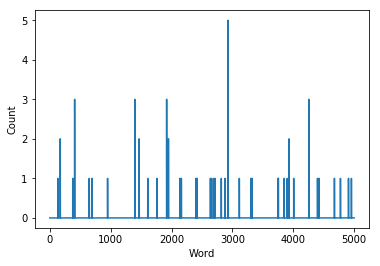

In [11]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

#### Comments: Reflecting on Bag-of-Words feature representation

The average sparsity level of BoW vectors in our training set (i.e. the percentage of entries in a BoW feature vector that are zero) is ...

In [12]:
print ("The average sparsity level of BoW vectors in training set is {0:.0f}%".format((np.count_nonzero(features_train==0)*100)/features_train.size))

The average sparsity level of BoW vectors in training set is 98%


### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. The figure below shows the number of appearances of each word in the training set against its rank.

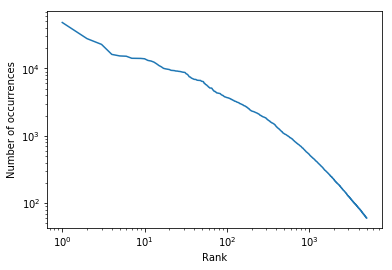

In [13]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

#### Comments: Zipf's law

The following cell shows the total number of occurrences of the most frequent word and that of the second most frequent word. The numbers do not follow Zipf's law. It must be because of the removal of the stopwords.

In [14]:
print ("Number of occurrences of the most frequent word: {}".format(sorted_word_freq[0]))
print ("Number of occurrences of the 2nd most frequent word: {}".format(sorted_word_freq[1]))

Number of occurrences of the most frequent word: 51696
Number of occurrences of the 2nd most frequent word: 48191


### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [15]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

/home/trang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


## Step 4: Classification using BoW features <a class="anchor" id="step4"></a>

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [16]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.81892, test = 0.72452


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. I will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. I will use default values for some of them, except one: `n_estimators` which I will tune using grid-search.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# The best n_estimators is 160
# Here is the range on which I performed GridSearchCV: params = {"n_estimators": range(10, 200, 10)}
# Use only 160 to avoid rerunning gridsearch on the whole range(10,200,10)
params = {"n_estimators": [160]}

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
    
    # Perform hyperparameter tuning
    grid_search = GridSearchCV(gbc, params, verbose=2)
    grid_search.fit(X_train, y_train)
    clf = grid_search.best_estimator_
    print ("Best n_estimators: ", grid_search.best_params_)
    
    # Print final training & test accuracy
    print ("[{}] Accuracy: train = {}, test = {}".format(
    clf.__class__.__name__,
    clf.score(X_train, y_train),
    clf.score(X_test, labels_test)))
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=160 ................................................
[CV] ................................. n_estimators=160, total= 2.6min
[CV] n_estimators=160 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] ................................. n_estimators=160, total= 2.6min
[CV] n_estimators=160 ................................................
[CV] ................................. n_estimators=160, total= 2.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.8min finished


Best n_estimators:  {'n_estimators': 160}
[GradientBoostingClassifier] Accuracy: train = 0.86256, test = 0.84244


### Adverserial testing

I've written a short movie review to trick the GBDT model. That is, a movie review with a clear positive or negative sentiment that the model will classify incorrectly.

In [18]:
# Write a sample review and set its true sentiment
my_review = "The actor's initial superb performance became average later on"
true_sentiment = 'neg'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps done for the training data
my_words = review_to_words(my_review)
my_vectorizer = CountVectorizer(vocabulary=vocabulary, preprocessor=lambda x: x, tokenizer=lambda x: x)
my_features = my_vectorizer.transform([my_words]).toarray()
my_features = pr.normalize(my_features)

# Then call the classifier to label it
print (clf2.predict(my_features))
print (clf2.score(my_features, [true_sentiment]))

['pos']
0.0


/home/trang/anaconda3/envs/aind/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


## Step 5: Switching gears - RNNs <a class="anchor" id="step5"></a>

We just saw how the task of sentiment analysis can be solved via a traditional machine learning approach: BoW + a nonlinear classifier. We now switch gears and use Recurrent Neural Networks, and in particular LSTMs, to perform sentiment analysis in Keras. Conveniently, Keras has a built-in [IMDb movie reviews dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) that we can use, with the same vocabulary size.

In [17]:
# import the built-in imdb dataset in Keras
from keras.datasets import imdb  

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

Using TensorFlow backend.


Loaded dataset with 25000 training samples, 25000 test samples


In [18]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

--- Review ---
[1, 4, 2, 716, 4, 65, 7, 4, 689, 4367, 2, 2343, 4804, 2, 2, 2, 2, 2315, 2, 2, 2, 2, 4, 2, 628, 2, 37, 9, 150, 4, 2, 4069, 11, 2909, 4, 2, 847, 313, 6, 176, 2, 9, 2, 138, 9, 4434, 19, 4, 96, 183, 26, 4, 192, 15, 27, 2, 799, 2, 2, 588, 84, 11, 4, 3231, 152, 339, 2, 42, 4869, 2, 2, 345, 4804, 2, 142, 43, 218, 208, 54, 29, 853, 659, 46, 4, 882, 183, 80, 115, 30, 4, 172, 174, 10, 10, 1001, 398, 1001, 1055, 526, 34, 3717, 2, 2, 2, 17, 4, 2, 1094, 871, 64, 85, 22, 2030, 1109, 38, 230, 9, 4, 4324, 2, 251, 2, 1034, 195, 301, 14, 16, 31, 7, 4, 2, 8, 783, 2, 33, 4, 2945, 103, 465, 2, 42, 845, 45, 446, 11, 1895, 19, 184, 76, 32, 4, 2, 207, 110, 13, 197, 4, 2, 16, 601, 964, 2152, 595, 13, 258, 4, 1730, 66, 338, 55, 2, 4, 550, 728, 65, 1196, 8, 1839, 61, 1546, 42, 2, 61, 602, 120, 45, 2, 6, 320, 786, 99, 196, 2, 786, 2, 4, 225, 4, 373, 1009, 33, 4, 130, 63, 69, 72, 1104, 46, 1292, 225, 14, 66, 194, 2, 1703, 56, 8, 803, 1004, 6, 2, 155, 11, 4, 2, 3231, 45, 853, 2029, 8, 30, 6, 117, 430

As seen above, the label is an integer (0 for negative, 1 for positive), and the review itself is stored as a sequence of integers. These are word IDs that have been preassigned to individual words. To map them back to the original words, we can use the dictionary returned by `imdb.get_word_index()`.

In [19]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

--- Review (with words) ---
['the', 'of', 'and', 'local', 'of', 'their', 'br', 'of', 'attention', 'widow', 'and', 'captures', 'parties', 'and', 'and', 'and', 'and', 'excitement', 'and', 'and', 'and', 'and', 'of', 'and', 'english', 'and', 'like', 'it', 'years', 'of', 'and', 'unintentional', 'this', 'hitchcock', 'of', 'and', 'learn', 'everyone', 'is', 'quite', 'and', 'it', 'and', 'such', 'it', 'bonus', 'film', 'of', 'too', 'seems', 'he', 'of', 'enough', 'for', 'be', 'and', 'editing', 'and', 'and', 'please', 'great', 'this', 'of', 'shoots', 'thing', '3', 'and', "it's", 'mentioning', 'and', 'and', 'given', 'parties', 'and', 'back', 'out', 'interesting', 'times', 'no', 'all', 'average', 'talking', 'some', 'of', 'nor', 'seems', 'into', 'best', 'at', 'of', 'every', 'cast', 'i', 'i', 'inside', 'keep', 'inside', 'large', 'viewer', 'who', 'obscure', 'and', 'and', 'and', 'movie', 'of', 'and', 'entirely', "you've", 'see', 'because', 'you', 'deals', 'successful', 'her', 'anything', 'it', 'of', 'ded

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths!

#### Comments: Variable length reviews

Below are the maximum review length (in terms of number of words) and the minimum in the training set:

In [20]:
# The review that has the max length
longest_review = max(X_train, key=len)

# The length of the longest review
print (len(longest_review))

# The length of the shortest review
print (len(min(X_train, key=len)))

2494
11


### Pad sequences

In order to feed this data into an RNN, all input documents must have the same length. Let's limit the maximum review length to `max_words` by truncating longer reviews and padding shorter reviews with a null value (0). We can accomplish this easily using the [`pad_sequences()`](https://keras.io/preprocessing/sequence/#pad_sequences) function in Keras. For now, set `max_words` to 500.

In [21]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# Pad sequences in X_train and X_test
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

### Design an RNN model for sentiment analysis

I am going to build an RNN using LSTM. The input is a sequence of words (technically, integer word IDs) of maximum length = `max_words`, and the output is a binary sentiment label (0 or 1).

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

learning_rate = 0.001
embed_dim = 300
model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim, input_length=max_words))
model.add(Dropout(0.2))
model.add(LSTM(512, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 300)          1500000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               1665024   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 3,165,537
Trainable params: 3,165,537
Non-trainable params: 0
_________________________________________________________________
None


### Train and evaluate the RNN model

Now we are ready to train the model. In Keras world, first we need to _compile_ the model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics we'd like to measure.

In [30]:
# Compile the model, specifying a loss function, optimizer, and metrics
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

Once compiled, we can kick off the training process. There are two important training parameters that we have to specify - **batch size** and **number of training epochs**, which together with the model architecture determine the total training time. I will use the typical value of 32 for `batch_size`. I will select a large number of epochs, 50, but will also use `EarlyStopping` so that the training will stop if validation loss doesn't fall for a number consecutive epochs. This technique usually saves time from training the model for too long without any improvement.

I will also split off a small portion of the training set to be used for validation during training. This will help monitor the training process and identify potential overfitting. I will use `validation_split` - a fraction of the training data for Keras to set aside for validation purpose. Validation metrics are evaluated once at the end of each epoch.

In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Specify training parameters: batch size and number of epochs
batch_size = 32
num_epochs = 50

# Save the model, so that we can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file

checkpointer = ModelCheckpoint(filepath=os.path.join(cache_dir, model_file), verbose=1, 
                               save_best_only=True)
# Stop training if the validation loss doesn't fall for 3 consecutive epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# Train the model, reserve some training data for validation
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_split=0.2, callbacks=[checkpointer, earlystopping], 
          verbose=2, shuffle=True)


Train on 20000 samples, validate on 5000 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.60519, saving model to cache/sentiment_analysis/rnn_model.h5
 - 980s - loss: 0.5727 - acc: 0.6956 - val_loss: 0.6052 - val_acc: 0.6524
Epoch 2/50
Epoch 00002: val_loss improved from 0.60519 to 0.28767, saving model to cache/sentiment_analysis/rnn_model.h5
 - 972s - loss: 0.3655 - acc: 0.8397 - val_loss: 0.2877 - val_acc: 0.8814
Epoch 3/50
Epoch 00003: val_loss improved from 0.28767 to 0.28130, saving model to cache/sentiment_analysis/rnn_model.h5
 - 973s - loss: 0.2248 - acc: 0.9113 - val_loss: 0.2813 - val_acc: 0.8926
Epoch 4/50
Epoch 00004: val_loss did not improve
 - 973s - loss: 0.1671 - acc: 0.9370 - val_loss: 0.2948 - val_acc: 0.8864
Epoch 5/50
Epoch 00005: val_loss did not improve
 - 973s - loss: 0.1296 - acc: 0.9533 - val_loss: 0.3350 - val_acc: 0.8840
Epoch 6/50
Epoch 00006: val_loss did not improve
 - 973s - loss: 0.0937 - acc: 0.9677 - val_loss: 0.4817 - val_acc: 0.8638


In [32]:
# Later we can load it using keras.models.load_model()
from keras.models import load_model
model = load_model(os.path.join(cache_dir, model_file))

Once we have trained the model, it's time to see how well it performs on unseen test data.

In [33]:
# Evaluate the model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy that I passed in metrics=['accuracy']

Test accuracy: 0.88288


## Step 6: Evaluation <a class="anchor" id="step6"></a>

### Comparing RNNs and Traditional Methods

The BoW + Gradient-Boosted Decision Trees (GBDT) model does a better job than the BoW + GaussianNB model. The RNN model outperforms both models. LSTM is able to remember over long sequences of inputs while the BoW models disregard word order. As seen in the adverserial testing part of BoW + GBDT, this limitation must have caused the model to classify the tricky review incorrectly.

### Steps taken to improve the accuracy of the RNN model

Below is the initial attempt that yielded an accuracy of 0.86792:

```
learning_rate = 0.01
embed_dim = 128
model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim, input_length=max_words))
model.add(Dropout(0.2))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
```

`Dropout` helped reduce overfitting. 

I then did the following experiments:

* Reduced the `learning_rate`. Higher learning rate, 0.01, must have caused the optimizer to overshoot the minimum. Lower rate made training more reliable, but also slower.
* Tried various values for `embed_dim` (64, 100, 128, and 300). 300 yielded the best validation and test accuracies, although at the cost of training time.
* Tried a) 1 LSTM layer (128 units) and b) 3 LSTM layers (32 units each). a) showed a better performance.
* Tried GRU instead of LSTM and the performance was similar.

After the experiments, the final model (trained above) achieved an accuracy of 0.88288.

```
learning_rate = 0.001
embed_dim = 300
model = Sequential()
model.add(Embedding(vocabulary_size, embed_dim, input_length=max_words))
model.add(Dropout(0.2))
model.add(LSTM(512, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
```